In [4]:
from time import time
import cv2
import argparse
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pdb
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import MiniBatchDictionaryLearning
from matplotlib import pyplot as plt
from skimage.exposure import rescale_intensity
from sklearn.feature_extraction import image

In [5]:
# image name
path = './Photos/2007060208_cam01.jpg'
#path = './Photos/jo.jpg'
im = cv2.imread(path)
print(im.shape[0],im.shape[1])

#b: longueur du patch
b = 32

#l: nombre total de patchs
l = 1024

#im

2376 4224


In [6]:
patches = image.extract_patches_2d(im, (b, b), l)
#patches.shape[0]*patches.shape[1]*patches.shape[2]
#patches[1]

In [7]:
def plot_patches(patches, fignum=None, low=0, high=0):
    """
    Given a stack of 2D patches indexed by the first dimension, plot the
    patches in subplots. 
    'low' and 'high' are optional arguments to control which patches
    actually get plotted. 'fignum' chooses the figure to plot in.
    """
    try:
        istate = plt.isinteractive()
        plt.ioff()
        if fignum is None:
            fig = plt.gcf()
        else:
            fig = plt.figure(fignum)
        if high == 0:
            high = len(patches)
        pmin, pmax = patches.min(), patches.max()
        dims = np.ceil(np.sqrt(high - low))
        for idx in range(high - low):
            spl = plt.subplot(dims, dims, idx + 1)
            #ax = plt.axis('off')
            im = plt.imshow(patches[idx])
            #cl = plt.clim(pmin, pmax)
        plt.show()
    finally:
        plt.interactive(istate)

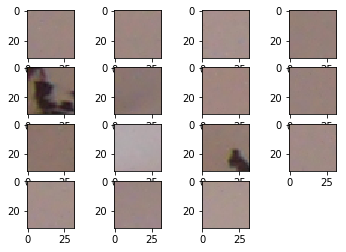

In [8]:
plot_patches(patches[10:25])

In [9]:
def matrix_to_column(patch,b,l):
    
    col = []
    
    for i in range(l):
        
        col.append(np.reshape(patch[i],(b*b*3,1)))
        
    return col

In [10]:
patch_vec = matrix_to_column(patches,b,l)

In [11]:
#Algorithme de l'Orthogonal Matching Pursuit - OMP
def OMP(X, D):
    # D le dictionnaire
    # X un vecteur
    
    K = len(D) # K représente le nombre de colonnes de D : size(D,2)
    
    #Initialisation
    Epsilon = 10**(-6) # La précision souhaitée servant de valeur d'arrêt
    iter = 0 # Nombre d'itérations réalisées initialisé à 0
    residuel = X #init du résiduel 0 égal au signal
    kmax = 10 # Le nombre d'itéaration maximum
    alpha = np.zeros((K, 1)) # Alpha est initialisée comme un vecteur de zéros 
    phi = [] # Phi est vide à l'étape 0. Il représente le dictionnaire actif.
    C = np.zeros((K,1)) # Vecteur des valeurs max de chaque colonne de D
    P = [] # P représente l'ensemble des indices des coefficients. Il est vide à l'étape 0.

    # A l'étape k>=1, on boucle tant que notre nombre d'itérations n'ont pas dépassé un seuil prédéfini et que notre critère d'arrêt est supérieur à un seuil epsilon prédéfini
    while ((kmax > iter) & (np.linalg.norm(residuel) > Epsilon)):
        # Sélection de l'atome identique au MP : celui qui contribue le plus au résiduel R^(0)
        for i in range(K):
            if (np.linalg.norm(D[:][i])!=0):
                C[i] = np.linalg.norm(np.transpose(D[:][i]) * residuel) / np.linalg.norm(D[:][i])
        # Ainsi on retient toujours l'indice correspondant au maximum 

        new = [abs(l) for l in C]
        mk = np.argmax(new)
        val = max(new)

        
        # On met à jour l'ensemble des indices P
        P.append(mk)
        # Construction de la matrice phi des colonnes Dmk (le dictionnaire actif) 
       
        
    
        # On met à jour les coefficients de notre représentation parcimonieuse
        if iter == 0:
            phi.append(D[:][mk])
            phi = phi[0]
            phi_T = np.transpose(phi)
            alpha[P] = np.matmul(np.matmul(np.linalg.pinv(np.matmul(phi_T,phi)),phi_T),X)
            #print('alpha =', alpha)
        else:
            phi = np.append(phi, D[:][mk], axis = 1)
            phi_T = np.transpose(phi)
            alpha[P[iter]] = np.matmul(np.matmul(np.linalg.pinv(np.matmul(phi_T,phi)),phi_T),X)[iter]
            #print('alpha =', alpha)
        # On met à jour notre résiduel
        residuel = X - np.matmul(phi,alpha[P])
        # On met à jour notre nombre d'itérations et on recommencer la boucle
        iter = iter + 1
    return alpha


In [35]:
# Algorithme KSVD 
def KSVD(D,X,Gamma):
    # D le dictionnaire
    # X le vecteur du signal d'origine
    # Gamma la matrice telle que X=D*Gamma

    K = len(D) #K le nombre d'atomes souhaités dans le dictionnaire

    # Etape 1 à K
    for i in range(K):
        # On commence par calculer l'erreur Err sur les l signaux sans tenir compte de la contribution de la ième colonne de D
        Mat = np.zeros((len(X[0]),K))
        for j in range(K):
            if j != i:
                Mat = Mat + np.matmul(D[:][j].reshape((len(D[:][j]),1)),Gamma[j][:].reshape((1,len(Gamma[j][:]))))

        Err = []
        for p in range(len(X)):
            Err.append(X[p] - Mat[p])

        # On ne garde que les coefficients non nuls de Gamma qu'on stocke dans wi le support, c'est à dire le vecteur des positions des coefficients non nuls.
        wi = []
        for i in range(0, len(Gamma[0])):
            if Gamma[i][:].any() != 0:
                wi.append(i)

        # Si ce support est vide, cela ne sert à rien de continuer et on peut passer à l'atome suivant.
        if len(wi) == 0:
            break

        # Représentation de Oméga composée uniquement de 0 ou de 1 permettant d'exprimer l'erreur de reconstruction par la suite.
        OMEGA = np.zeros((len(X),len(wi)))
        for w in range(len(wi)):
            OMEGA[wi[w]][w] = 1

        # Erreur de reconstruction sans tenir compte des atomes correspondant aux coefficients non nuls de Gamma
        ERR = np.matmul(Err,OMEGA)
        
        # On réalise enfin une décomposition SVD de ERR
        U, S, V = np.linalg.svd(ERR[0])
        
        # Mise à jour du dictionnaire D
        D[:][i] = U[:][0]

        # Mise à jour de Gamma
        Gamma[i,wi] = S[0] * V[0][:].reshape((1,9))

    return D, Gamma

In [13]:
#Algorithme d'apprentissage d'un dictionnaire par KSVD pour OMP
def Apprentissage_OMP(X,k,L):
    # X le vecteur du signal d'origine 
    # k le nombre d'atomes souhaités dans le dictionnaire
    # L le nombre de mises à jour 

    # Initialisation
    D=X[:][0:k]
    
    
    # Normalisation des colonnes de D avec les k premières colonnes de X
    for j in range(k):
            D[:][j]=(D[:][j]-np.mean(D[:][j]))/(np.linalg.norm(D[:][j])**2)
    # Gamma de taille k,l
    Gamma=np.zeros((k,len(X)))

    # On répète L fois les étapes suivantes
    for j in range(L):
        for i in range(len(X)):
            print("Step ", i)
            # On met à jour les coefficients de Gamma
            Gamma[:][i]=OMP(X[:][i],D).reshape(9)

         # Mise à jour du dictionnaire de de Gamma
        #D,Gamma = KSVD(D,X,Gamma)
        print(Gamma)
        print(D)
        #print(j)
    return D, Gamma

In [14]:
D, Gamma = Apprentissage_OMP(patch_vec[0:9],9,1)

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Step  6
Step  7
Step  8
[[  -80153.12526785    40151.31445701   162642.1106605         0.
   -291332.9065285    534238.25900478        0.           314204.98128974
         0.        ]
 [       0.                0.            70765.45762712        0.
         0.            22438.67540817        0.                0.
         0.        ]
 [   36289.86591843        0.          -141829.89784087   372645.24182297
         0.                0.                0.           136177.43941047
         0.        ]
 [       0.                0.           111598.86440678        0.
   -154296.12524794        0.                0.                0.
         0.        ]
 [ -807426.28954636  -207378.67486261   107382.34463277        0.
  -1480987.09705474    17690.65022659  1261738.50827132   667831.76440592
         0.        ]
 [  371817.45976102  -153102.02762124   102841.55367232   432428.91127439
     25223.23109326        0.                0.          

In [36]:
D, Gamma = KSVD(D, patch_vec[0:9], Gamma)

In [37]:
D

[array([[180],
        [162],
        [161],
        ...,
        [177],
        [157],
        [152]], dtype=uint8), array([[ 62],
        [ 44],
        [ 45],
        ...,
        [135],
        [110],
        [100]], dtype=uint8), array([[ 36],
        [ 25],
        [ 27],
        ...,
        [137],
        [115],
        [104]], dtype=uint8), array([[164],
        [141],
        [133],
        ...,
        [158],
        [136],
        [131]], dtype=uint8), array([[156],
        [132],
        [126],
        ...,
        [154],
        [132],
        [127]], dtype=uint8), array([[145],
        [125],
        [124],
        ...,
        [153],
        [130],
        [128]], dtype=uint8), array([[ 28],
        [ 25],
        [ 27],
        ...,
        [156],
        [134],
        [129]], dtype=uint8), array([[170],
        [149],
        [147],
        ...,
        [169],
        [150],
        [147]], dtype=uint8), array([[143],
        [124],
        [121],
        ...,
      

In [38]:
Gamma

array([[-8.01531253e+04,  4.01513145e+04,  1.62642111e+05,
         0.00000000e+00, -2.91332907e+05,  5.34238259e+05,
         0.00000000e+00,  3.14204981e+05,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  7.07654576e+04,
         0.00000000e+00,  0.00000000e+00,  2.24386754e+04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.62898659e+04,  0.00000000e+00, -1.41829898e+05,
         3.72645242e+05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.36177439e+05,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.11598864e+05,
         0.00000000e+00, -1.54296125e+05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.07426290e+05, -2.07378675e+05,  1.07382345e+05,
         0.00000000e+00, -1.48098710e+06,  1.76906502e+04,
         1.26173851e+06,  6.67831764e+05,  0.00000000e+00],
       [ 3.71817460e+05, -1.53102028e+05,  1.02841554e+05,
         4.32428911e+05,  2.52232311e+04,  0.000000